# Методы оптимизации
## Лабораторная работа 3: Метод барьеров


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
from scipy.sparse import diags
from sklearn.datasets import load_svmlight_file

import oracles
from optimization import barrier_method_lasso

sns.set_theme()

np.random.seed(0)

datasets_path = './datasets/'

## 1. Основные задачи

1. Реализовать процедуру вычисления зазора двойственности (функция `lasso_duality_gap` в модуле `oracles.py`).
2. Выписать вспомогательную функцию f_t(x, u), минимизируемую в методе барьеров. Выписать систему линейных уравнений, задающую ньютоновоское направление dk = (d_x_k, d_u_k). 
Предложить способ решения этой системы и прокомментировать его достоинства и недостатки. Для текущей точки (x, u) и направления dk определите максимальную допустимую длину шага α. Какую начальную точку (x0, u0) можно выбрать для метода барьеров?
3. Реализовать метод барьеров (функция `barrier_method_lasso` в модуле `optimization.py`)\
Проверка работы


In [4]:
file_name = 'w8a.txt'
file_path = datasets_path + file_name

X, y = load_svmlight_file(file_path)
x0 = np.zeros(X.shape[1])
u0 = np.ones(X.shape[1])
reg_coef = 1/X.shape[0]

In [5]:
t = 1
gamma = 0.01

x, message, history = barrier_method_lasso(X, y, reg_coef, x0, u0, gamma=gamma, t_0=t, trace=True)
x, message


((array([-5.23947553e-02, -1.35794817e-01, -3.51560182e-01, -2.33260615e-01,
         -1.70345235e-01, -1.09649746e-01,  1.75770749e-02,  5.14624628e-02,
          2.92907319e-02, -1.28568713e-01, -1.06486582e-01,  9.33818329e-02,
         -6.47303035e-03,  2.23301973e-03, -1.29141488e-02, -2.21390806e-01,
          1.07663222e-01, -4.51399862e-03, -1.87122321e-01, -1.61174183e-01,
         -2.22673215e-01,  5.30933151e-02, -1.91252496e-01,  1.45950415e-03,
         -3.18779637e-02,  5.11419507e-03,  9.91965315e-03, -6.23191664e-02,
         -3.23446978e-02, -1.06610598e-02, -4.85472706e-02, -1.13878426e-02,
          6.32161426e-03, -1.07664273e-02, -2.29855903e-01, -1.12627104e-01,
         -1.62270740e-01, -1.46584881e-01, -3.34875075e-01,  4.36509724e-01,
         -1.25094814e-01,  6.33384322e-01,  6.33384323e-01, -7.25514549e-02,
          1.31417258e-02, -6.25034516e-01, -7.39041961e-03,  1.04990250e-01,
          8.25557705e-01,  8.02992597e-02,  9.71666232e-02,  4.94131841e-02,

## 2. Эксперименты

### 2.1. Исследование чувствительности метода барьеров к выбору параметра $γ$ (скорость увеличения $t_k$) и $ϵ_{inner}$ (точность для метода Ньютона)

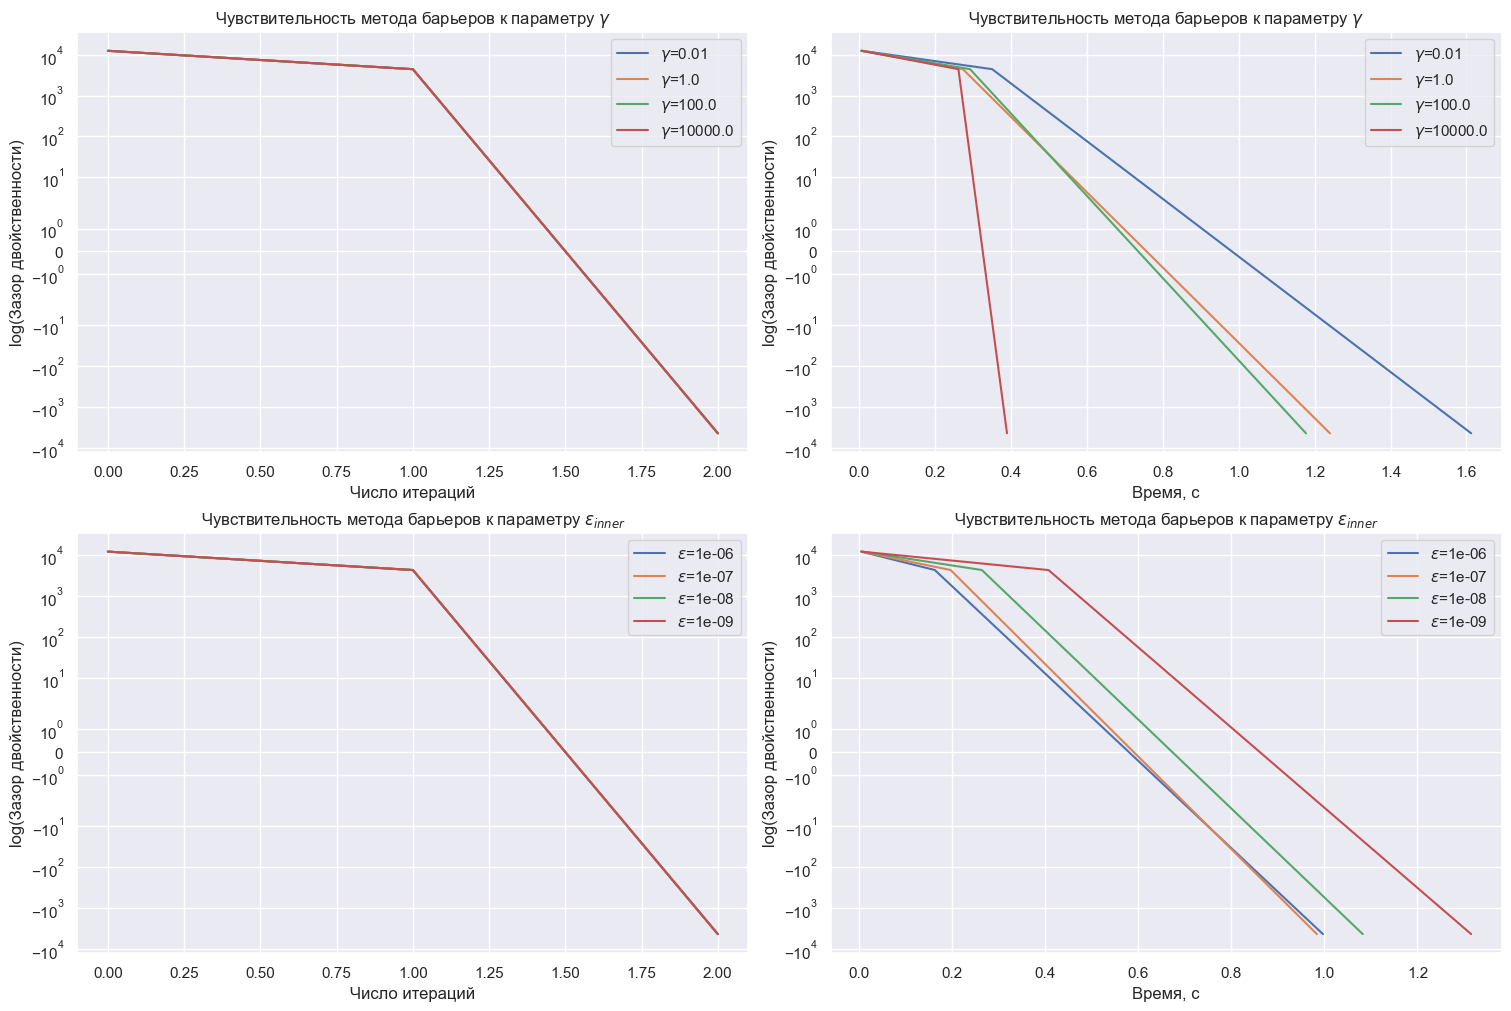

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10), constrained_layout=True);

gammas = [1e-2, 1e0, 1e2, 1e4]
epsilons_inner = [1e-6, 1e-7, 1e-8, 1e-9]

for i, gamma in enumerate(gammas):
    x, message, history = barrier_method_lasso(X, y, reg_coef, x0, u0, gamma=gamma, trace=True)
    axes[0][0].plot(range(len(history['time'])), history['duality_gap'], label=fr'$\gamma$={gamma}')
    axes[0][1].plot(history['time'], history['duality_gap'], label=fr'$\gamma$={gamma}')
    axes[0][0].set_yscale('symlog')
    axes[0][1].set_yscale('symlog')

for i, epsilon_inner in enumerate(epsilons_inner):
    x, message, history = barrier_method_lasso(X, y, reg_coef, x0, u0, tolerance_inner=epsilon_inner, trace=True)
    axes[1][0].plot(range(len(history['time'])), history['duality_gap'], label=fr'$\epsilon$={epsilon_inner}')
    axes[1][1].plot(history['time'], history['duality_gap'], label=fr'$\epsilon$={epsilon_inner}')
    axes[1][0].set_yscale('symlog')
    axes[1][1].set_yscale('symlog')

axes[0][0].set_ylabel('log(Зазор двойственности)')
axes[0][0].set_xlabel('Число итераций')
axes[0][0].set_title('Чувствительность метода барьеров к параметру $\\gamma$')
axes[0][1].set_ylabel('log(Зазор двойственности)')
axes[0][1].set_xlabel('Время, с')
axes[0][1].set_title('Чувствительность метода барьеров к параметру $\\gamma$')
axes[0][0].legend()
axes[0][1].legend()

axes[1][0].set_ylabel('log(Зазор двойственности)')
axes[1][0].set_xlabel('Число итераций')
axes[1][0].set_title('Чувствительность метода барьеров к параметру $\\epsilon_{inner}$')
axes[1][1].set_ylabel('log(Зазор двойственности)')
axes[1][1].set_xlabel('Время, с')
axes[1][1].set_title('Чувствительность метода барьеров к параметру $\\epsilon_{inner}$')
axes[1][0].legend()
axes[1][1].legend()

### 2.2. Исследование поведения метода барьеров для различных значений размерности пространства $n$, размера выборки $m$ и коэффициента регуляризации $λ$

c:\Users\kshch\Projects\Методы_оптимизации\ИТМО\Лабораторные\work3\oracles.py:75: RuntimeWarning: invalid value encountered in log
  return self.t * self.lasso_func(x, u) - np.sum(np.log(u + x) + np.log(u - x))
c:\Users\kshch\Projects\Методы_оптимизации\ИТМО\Лабораторные\work3\oracles.py:85: RuntimeWarning: overflow encountered in square
  hess_xx = self.A.T @ self.A * self.t + np.diag(1 / (u - x) ** 2 + 1 / (u + x) ** 2)
c:\Users\kshch\Projects\Методы_оптимизации\ИТМО\Лабораторные\work3\oracles.py:86: RuntimeWarning: overflow encountered in square
  hess_xu = np.diag(1 / (u + x) ** 2 - 1 / (u - x) ** 2)
c:\Users\kshch\Projects\Методы_оптимизации\ИТМО\Лабораторные\work3\oracles.py:87: RuntimeWarning: overflow encountered in square
  hess_uu = np.diag(1 / (u + x) ** 2 + 1 / (u - x) ** 2)
c:\Users\kshch\Projects\Методы_оптимизации\ИТМО\Лабораторные\work3\oracles.py:75: RuntimeWarning: invalid value encountered in log
  return self.t * self.lasso_func(x, u) - np.sum(np.log(u + x) + np.log

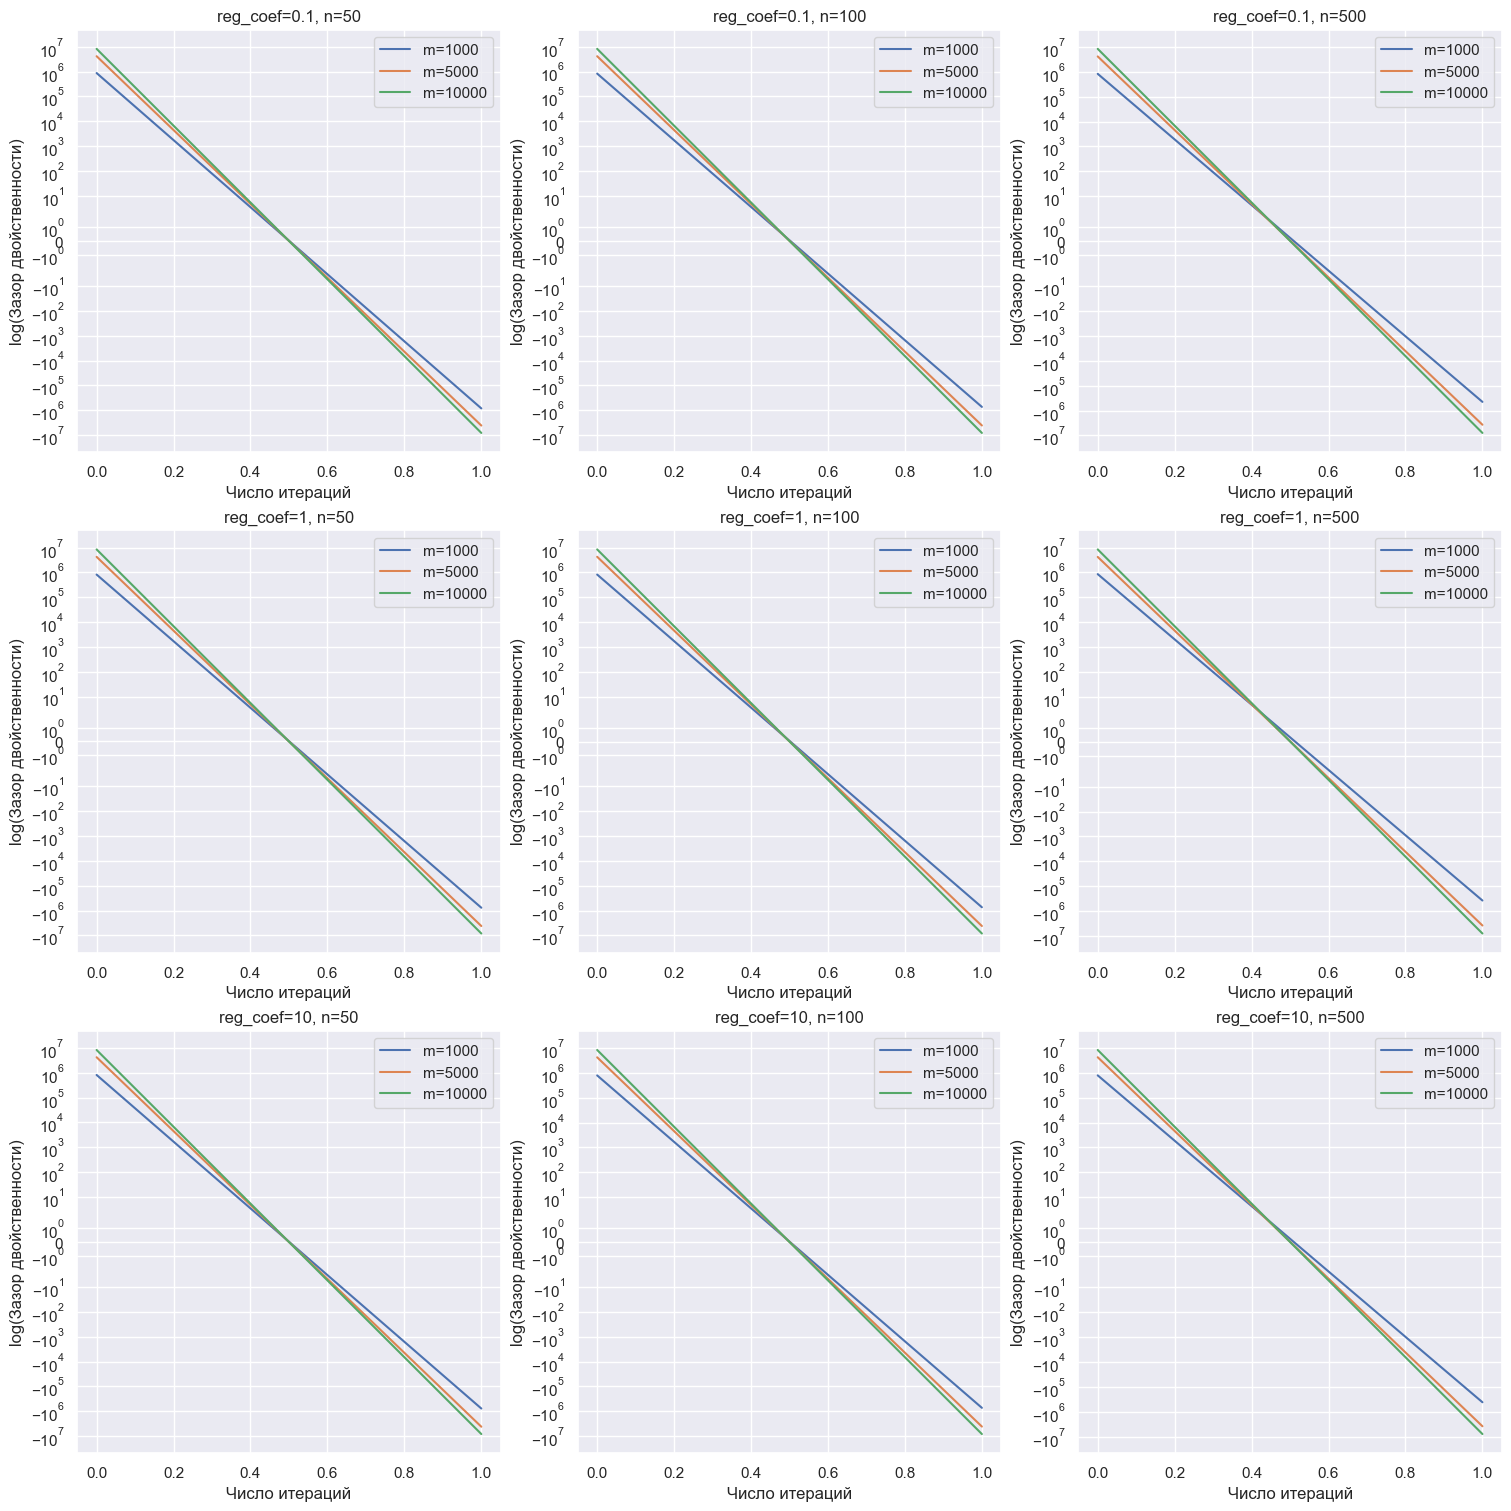

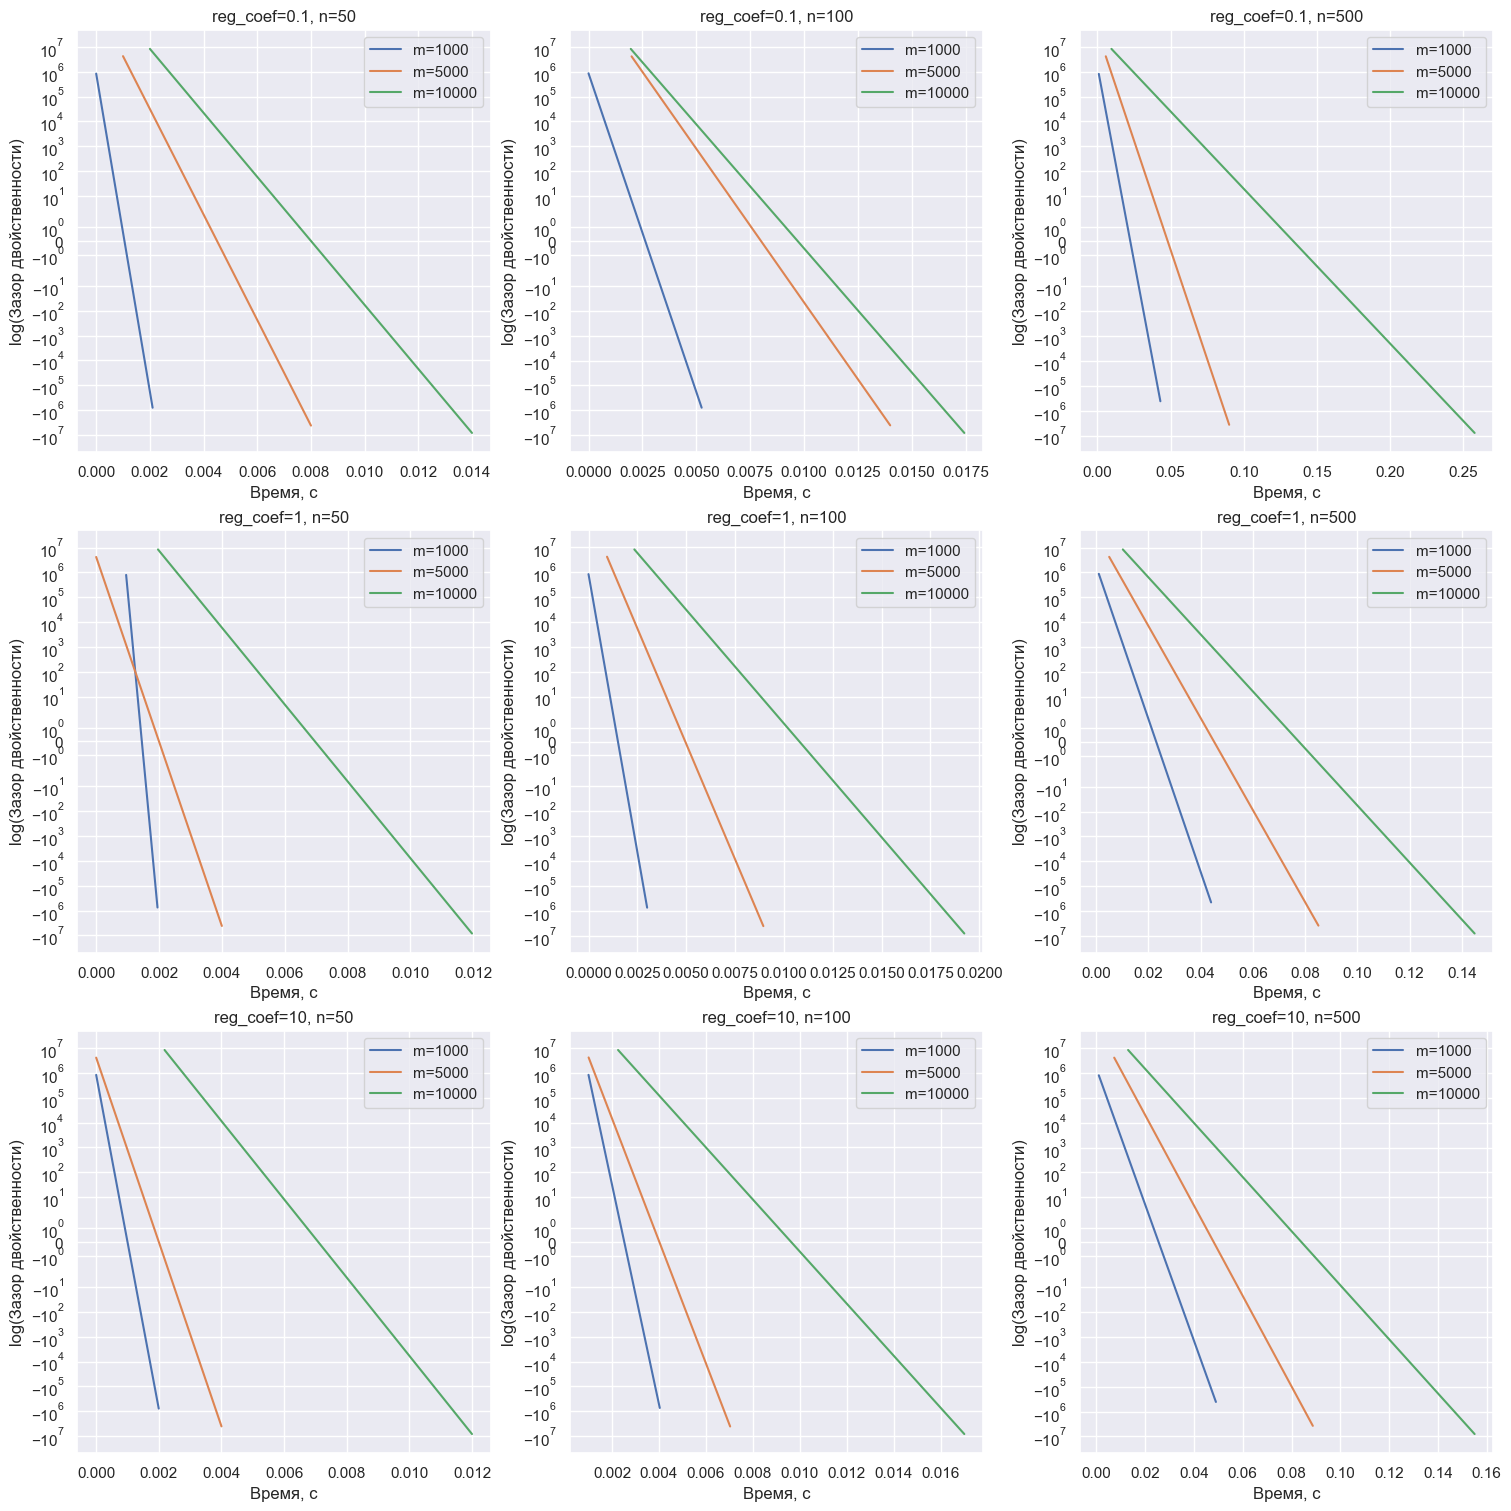

In [12]:
ns = [50, 100, 500]
ms = [1000, 5000, 10000]
reg_coefs = [0.1, 1, 10]

plt.figure(figsize=(15,15), constrained_layout=True)
for i, reg_coef in enumerate(reg_coefs):
    for j, n in enumerate(ns):
        for m in ms:
            A = np.random.uniform(low=-100, high=100, size=(m, n))
            b = np.random.uniform(low=-100, high=100, size=m)
            x0 = np.zeros(n)
            u0 = np.array([100] * n)
            x, message, history = barrier_method_lasso(A, b, reg_coef, x0, u0, trace=True)
            plt.subplot(3, 3, i * 3 + j + 1)
            plt.plot(range(len(history['time'])), history['duality_gap'], label=f'm={int(m)}')
            plt.yscale('symlog')
            plt.xlabel('Число итераций')
            plt.ylabel('log(Зазор двойственности)')
            plt.title(f'reg_coef={reg_coef}, n={int(n)}')
            plt.legend()


plt.figure(figsize=(15,15), constrained_layout=True)
for i, reg_coef in enumerate(reg_coefs):
    for j, n in enumerate(ns):
        for m in ms:
            A = np.random.uniform(low=-100, high=100, size=(m, n))
            b = np.random.uniform(low=-100, high=100, size=m)
            x0 = np.zeros(n)
            u0 = np.array([100] * n)
            x, message, history = barrier_method_lasso(A, b, reg_coef, x0, u0, trace=True)
            plt.subplot(3, 3, i * 3 + j + 1)
            plt.plot(history['time'], history['duality_gap'], label=f'm={int(m)}')
            plt.yscale('symlog')
            plt.xlabel('Время, с')
            plt.ylabel('log(Зазор двойственности)')
            plt.title(f'reg_coef={reg_coef}, n={int(n)}')
            plt.legend()